<a href="https://colab.research.google.com/github/joaochenriques/WaveEnergyStatistics/blob/main/WaveEnergyStatistics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Wave energy statistics from 2002 to 2023

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as mpl
import sys, pathlib
import itertools
from scipy import optimize
from sortedcontainers import SortedDict

from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,AutoMinorLocator)

import pathlib, subprocess

def cmdcall( cmd ):
    output = subprocess.getoutput( cmd )
    print(output)

if not pathlib.Path("mpl_utils.py").exists():
  cmdcall( 'curl -O https://raw.githubusercontent.com/joaochenriques/ipynb_libs/main/mpl_utils.py' )

import mpl_utils as mut
mut.config_plots()

markers = ( 'o', '^', 's', 'v', 'H', 'X', 'P' )

from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('svg')

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  3921  100  3921    0     0  20746      0 --:--:-- --:--:-- --:--:-- 20746


In [2]:
cmdcall( 'wget https://github.com/MaxGhenis/random/raw/master/Roboto-Regular.ttf' )
matplotlib.font_manager.fontManager.addfont('Roboto-Regular.ttf')
# import matplotlib.font_manager
# for f in matplotlib.font_manager.fontManager.ttflist:
#     print(f.name)

--2023-07-06 14:08:06--  https://github.com/MaxGhenis/random/raw/master/Roboto-Regular.ttf
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/MaxGhenis/random/master/Roboto-Regular.ttf [following]
--2023-07-06 14:08:06--  https://raw.githubusercontent.com/MaxGhenis/random/master/Roboto-Regular.ttf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 145348 (142K) [application/octet-stream]
Saving to: ‘Roboto-Regular.ttf’

     0K .......... .......... .......... .......... .......... 35% 2.23M 0s
    50K .......... .......... .......... .......... .......... 70% 5.08M 0s
   100K .......... .......... ..

In [3]:
cmdcall( 'pip install pylatex' )
from pylatex import LongTable, Tabular, MultiColumn, MultiRow, TextColor
from pylatex.utils import bold

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for pylatex: filename=PyLaTeX-1.4.1-py3-none-any.whl size=42799 sha256=aa1a4c392eb094bd3da220d860341efb1d5d7f11b629231b56576685a8dd6534
  Stored in directory: /root/.cache/pip/wheels/7d/6d/a1/716565cec073a7ccebc1eb9a7c061658a75d5559c16f0ee875
Successfully built pylatex


In [4]:
cmdcall( 'pip install font-roboto' )

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 29.1 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for font-roboto: filename=font_roboto-0.0.1-py3-none-any.whl size=2359737 sha256=edaaf6e98b5837d7ee38b5c409f1f6b569981b45562f2979a6808b6cb3539503
  Stored in directory: /root/.cache/pip/wheels/a3/9e/ce/7bf12c0d9d2b230d1457d6b7c776aabdc6a01e9ab824db2462
Successfully built font-roboto


In [5]:
cmdcall( 'pip install unidecode' )
from unidecode import unidecode

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.9/235.9 kB 5.8 MB/s eta 0:00:00


In [6]:
cmdcall( 'pip install dataclassy' )
from dataclassy import dataclass

In [7]:
cmdcall( 'pip install iso3166' )
from iso3166 import countries

country_lst = []
for c in countries:
    country_lst.append( c.name )

In [8]:
def left_align( df ):
    left_aligned_df = df.style.set_properties(**{'text-align': 'left'})
    left_aligned_df = left_aligned_df.set_table_styles(
        [dict(selector='th', props=[('text-align', 'left')])]
    )
    return left_aligned_df

# Scopus advanced search query

```
TITLE-ABS-KEY-AUTH(WAVE-ENERGY) AND PUBYEAR AFT 2001 AND DOCTYPE(ar OR re) AND
(
    SRCTITLE(applied-energy) OR
    SRCTITLE(applied-ocean-research) OR
    SRCTITLE(energy) OR
    SRCTITLE(energy-conversion-and-management ) OR
    SRCTITLE(energies) OR
    SRCTITLE(ieee-transactions-on-sustainable-energy) OR
    SRCTITLE(iet-renewable-power-generation) OR
    SRCTITLE(international-journal-of-marine-energy ) OR
    SRCTITLE(international-journal-of-offshore-and-polar-engineering ) OR
    SRCTITLE(journal-of-offshore-mechanics-and-arctic-engineering) OR
    SRCTITLE(Journal-of-Ocean-Engineering-and-Marine-Energy) OR
    SRCTITLE(ocean-engineering) OR
    SRCTITLE(marine-structures) OR
    SRCTITLE(renewable-energy) OR
    SRCTITLE(renewable-sustainable-energy-reviews)
)
```

In [9]:
filename = 'scopus_20230706_since_2002.csv'

if not pathlib.Path( f"{filename}").exists():
    cmdcall( f'curl -O https://raw.githubusercontent.com/joaochenriques/PAS_STATS/main/{filename}' )

df = pd.read_csv( filename )

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 5082k  100 5082k    0     0  9831k      0 --:--:-- --:--:-- --:--:-- 9812k


In [10]:
authors_lst = df['Authors']
authors_ID_lst = df['Author(s) ID']
affiliations_lst = df['Affiliations']
title_lst = df['Title']
journal_lst = df['Source title']
year_lst = df['Year']
citations_lst = df['Cited by']
DOI_lst = df['DOI']
stage_lst = df['Publication Stage']

replacements_dic = {
    'Ireland (formerly at the University of Plymouth)': 'Ireland',
    'Univ. Paris6': 'France',
    'Chinese Academy of Sciences': 'China',
    'Instituto Superior Tx000E9': 'Portugal'
}

# Max number of table entries

In [11]:
max_entries = 10

global_tab = {}

# Countries ordered by percentage of the authors's country

In [12]:
countries_frac_dic = {}
total_valid_papers = 0

for n, ( affiliations, stage ) in enumerate( zip( affiliations_lst, stage_lst ) ):
    if stage == 'Final' and affiliations == affiliations: # detect NANs
        total_valid_papers += 1

        institutions_lst = affiliations.split( ';' )
        frac = 1.0 / len(institutions_lst)

        for institution in institutions_lst:
            country = institution.rsplit( ',', 1 )[-1].strip()

            if country in replacements_dic:
                country = replacements_dic[country]

            if not country in countries_frac_dic:
                countries_frac_dic[country] = frac
            else:
                countries_frac_dic[country] += frac

sorted_country_frac_rank = { k: v for k, v in sorted( countries_frac_dic.items(), key=lambda item: item[1], reverse=True ) }

df_country_name_lst = []
df_country_num_lst = []

col_name = f"Num papers out of {total_valid_papers}"
df_country_dic = {
        "Country": df_country_name_lst,
        col_name: df_country_num_lst
}

for n, ( name, num ) in enumerate( sorted_country_frac_rank.items() ):
    if n == max_entries: break
    df_country_name_lst.append( name )
    df_country_num_lst.append( int(num) )

df = pd.DataFrame( df_country_dic )
df.index = df.index + 1
df.head(20)

,Country,Num papers out of 3651
1,China,749
2,United Kingdom,371
3,United States,367
4,Portugal,221
5,Spain,178
6,Italy,158
7,Ireland,156
8,India,148
9,Australia,146
10,Sweden,104


# Generate latex table

In [13]:
@dataclass
class data:
    name: str = None
    num_papers: int = 0
    citations: int = 0

In [14]:
papers_dic = {}

for n, ( authors, authors_ID, citations, DOI, stage ) in enumerate( zip( authors_lst, authors_ID_lst, citations_lst, DOI_lst, stage_lst ) ):
    if stage == 'Final' and authors == authors and authors_ID == authors_ID: # check NANs
        for ( author, ID ) in zip( authors.split(';'), str( authors_ID ).split(';') ):
            author = author.strip()
            ID = ID.strip()

            if ID in papers_dic:
                papers_dic[ID].num_papers += 1
                papers_dic[ID].citations += int(citations)
            else:
                papers_dic[ID] = data( author, 1, int(citations) )

In [15]:
sorted_papers_dic = { k: v for k, v in sorted( papers_dic.items(), key=lambda item: item[1].num_papers, reverse=True ) }

df_authors_name_lst = []
df_authors_num_lst = []

df_authors_dic = {
        "Author": df_authors_name_lst,
        "Num papers": df_authors_num_lst
}

for n, dt in enumerate( sorted_papers_dic.values() ):
    if n == max_entries: break
    df_authors_name_lst.append( dt.name )
    df_authors_num_lst.append( dt.num_papers )


df = pd.DataFrame( df_authors_dic )
df.index = df.index + 1

left_align( df.head(20) )

,Author,Num papers
1,Ringwood J.V.,92
2,Iglesias G.,80
3,Guedes Soares C.,66
4,Gato L.M.C.,64
5,Henriques J.C.C.,62
6,Falcão A.F.O.,59
7,Ning D.,48
8,Greaves D.,45
9,Leijon M.,45
10,Shi H.,44


In [16]:
sorted_citations_dic = { k: v for k, v in sorted( papers_dic.items(), key=lambda item: item[1].citations, reverse=True ) }

df_citations_name_lst = []
df_citations_num_lst = []

df_citations_dic = {
        "Author": df_citations_name_lst,
        "Citations": df_citations_num_lst
}

for n, dt in enumerate( sorted_citations_dic.values() ):
    if n == max_entries: break
    df_citations_name_lst.append( dt.name )
    df_citations_num_lst.append( dt.citations )

df = pd.DataFrame( df_citations_dic )
df.index = df.index + 1
left_align( df.head(20) )

,Author,Citations
1,Falcão A.F.O.,6150
2,Iglesias G.,4977
3,Wang Z.L.,4776
4,Ringwood J.V.,3230
5,Guedes Soares C.,2724
6,Babarit A.,2557
7,Henriques J.C.C.,2410
8,Moan T.,2368
9,Carballo R.,2037
10,Gato L.M.C.,2024


# Most cited papers

In [17]:
@dataclass
class paper_rank:
    authors: str = None
    title: str = None
    journal: str =None
    year: int = 0
    DOI: str = None
    citations: int = 0

In [18]:
papers_rank_dic = {}

for n, ( authors, title, journal, year, DOI, citations, stage ) in enumerate( zip( authors_lst, title_lst, journal_lst, year_lst, DOI_lst, citations_lst, stage_lst ) ):
    if stage == 'Final' and authors == authors: # check NANs
        papers_rank_dic[DOI] = paper_rank( authors, title, journal, year, DOI, int( citations ) )

In [19]:
sorted_papers_rank_dic = { k: v for k, v in sorted( papers_rank_dic.items(), key=lambda item: item[1].citations, reverse=True ) }

df_authors_name_lst = []
df_title_lst = []
df_journal_lst = []
df_year_lst = []
df_DOI_lst = []
df_citations_lst = []

df_papers_rank_dic = {
        "Authors": df_authors_name_lst,
        "Title": df_title_lst,
        "Journal": df_journal_lst,
        "Year": df_year_lst,
        # "DOI": df_DOI_lst,
        "citations": df_citations_lst
}


for n, dt in enumerate( sorted_papers_rank_dic.values() ):
    df_authors_name_lst.append( dt.authors )
    df_title_lst.append( dt.title )
    df_journal_lst.append( dt.journal )
    df_year_lst.append( dt.year )
    df_DOI_lst.append( dt.DOI )
    df_citations_lst.append( dt.citations )

df_authors_name_lst[0] = 'Falcão A.F.O.'

df = pd.DataFrame( df_papers_rank_dic )
df.index = df.index + 1
left_align( df.head(20) )

,Authors,Title,Journal,Year,citations
1,Falcão A.F.O.,Wave energy utilization: A review of the technologies,Renewable and Sustainable Energy Reviews,2010,2047
2,Drew B.; Plummer A.R.; Sahinkaya M.N.,A review of wave energy converter technology,"Proceedings of the Institution of Mechanical Engineers, Part A: Journal of Power and Energy",2009,874
3,Clément A.; McCullen P.; Falcão A.; Fiorentino A.; Gardner F.; Hammarlund K.; Lemonis G.; Lewis T.; Nielsen K.; Petroncini S.; Pontes M.-T.; Schild P.; Sjöström B.-O.; Sørensen H.C.; Thorpe T.,Wave energy in Europe: Current status and perspectives,Renewable and Sustainable Energy Reviews,2002,842
4,Falnes J.,A review of wave-energy extraction,Marine Structures,2007,814
5,Wang Z.L.; Jiang T.; Xu L.,Toward the blue energy dream by triboelectric nanogenerator networks,Nano Energy,2017,734
6,Falcão A.F.O.; Henriques J.C.C.,Oscillating-water-column wave energy converters and air turbines: A review,Renewable Energy,2016,598
7,Babarit A.; Hals J.; Muliawan M.J.; Kurniawan A.; Moan T.; Krokstad J.,Numerical benchmarking study of a selection of wave energy converters,Renewable Energy,2012,560
8,López I.; Andreu J.; Ceballos S.; Martínez De Alegría I.; Kortabarria I.,Review of wave energy technologies and the necessary power-equipment,Renewable and Sustainable Energy Reviews,2013,542
9,Gunn K.; Stock-Williams C.,Quantifying the global wave power resource,Renewable Energy,2012,439
10,Pérez-Collazo C.; Greaves D.; Iglesias G.,A review of combined wave and offshore wind energy,Renewable and Sustainable Energy Reviews,2015,409


# Generate plot of the papers per year

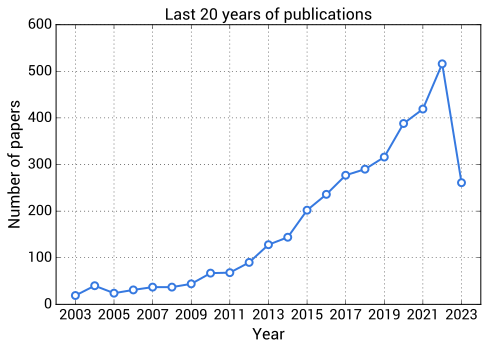

In [20]:
mpl.rc('font', family='Roboto')

# year_dic = {i:0 for i in range( min( year_lst ), max( year_lst )+1 ) }
year_dic = {i:0 for i in range( 2003, 2023+1 ) }

for n, ( year, stage ) in enumerate( zip( year_lst, stage_lst ) ):
    if stage == 'Final' and affiliations == affiliations: # detect NANs
        if year > 2002:
            year_dic[year] += 1

mpl.figure( 1, figsize=(1.2*6,1.2*4) )
mpl.plot( year_dic.keys(), year_dic.values(), 'o-',
         linewidth=2, color='#3679e0',
         markersize=7, markerfacecolor='w', markeredgewidth=2,
         markeredgecolor='#3679e0' )
mpl.xlim( (2002, 2024) )
mpl.grid()
mpl.xlabel( 'Year' )
mpl.ylabel( 'Number of papers' )
mpl.title( 'Last 20 years of publications' )#.set_fontname("Roboto condensed")


mpl.gca().set_axisbelow(True)
# mpl.gca().set_xticks( range( min( year_lst ), max( year_lst )+1, 2 ) );
mpl.gca().set_xticks( range( 2003, 2023+1, 2 ) );
mpl.savefig( 'PubsLast20Years.pdf', bbox_inches='tight', pad_inches=0.02 )
mpl.savefig( 'PubsLast20Years.svg', bbox_inches='tight', pad_inches=0.02 )

# df_year_dic = {
#     'Year': year_dic.keys(),
#     'Num papers': year_dic.values()
# }

# df = pd.DataFrame( df_year_dic )
# df.index = df.index + 1
# df

# Generate latex table

In [21]:
C1_Countries  = list( df_country_dic.values() )[0]
C1_num_papers = list( df_country_dic.values() )[1]

C2_Author     = list( df_authors_dic.values() )[0]
C2_num_papers = list( df_authors_dic.values() )[1]

C3_Author  = list( df_citations_dic.values() )[0]
C3_num_cit = list( df_citations_dic.values() )[1]

In [22]:
for n in range( max_entries ):
    if 'Portugal' in C1_Countries[n]:
        C1_Countries[n] = bold( C1_Countries[n] )
    if 'Henriques' in C2_Author[n]:
        C2_Author[n] = bold( C2_Author[n] )
    if 'Henriques' in C3_Author[n]:
        C3_Author[n] = bold( C3_Author[n] )

In [23]:
data_table = Tabular('|c|cl|cl|cl|')
data_table.add_hline()

data_table.add_row( ( MultiRow(2, data='Ordem'), 'Número', MultiRow(2, data='País'), 'Número', MultiRow(2, data='Autor'), 'Número', MultiRow(2, data='Autor') ) )
data_table.add_row( ( '', 'artigos', '', 'artigos', '', 'citações', '' ) )

data_table.add_hline()
data_table.add_hline()

for n in range( max_entries ):
    row = [n+1, C1_Countries[n], C1_num_papers[n],
                C2_Author[n], C2_num_papers[n],
                C3_Author[n], C3_num_cit[n] ]

    if n % 2 == 0:
        data_table.add_row( row, color='shadecolor' )
    else:
        data_table.add_row( row )
data_table.add_hline()

data_table.generate_tex('tablefile')